# Project 6: Analyzing Stock Sentiment from Twits
## Instructions
Each problem consists of a function to implement and instructions on how to implement the function.  The parts of the function that need to be implemented are marked with a `# TODO` comment.

## Packages
When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages will be imported for you. We recommend you don't add any import statements, otherwise the grader might not be able to run your code.

### Load Packages

In [376]:
import json
import nltk
import os
import random
import re
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn, optim
import torch.nn.functional as F

## Introduction
When deciding the value of a company, it's important to follow the news. For example, a product recall or natural disaster in a company's product chain. You want to be able to turn this information into a signal. Currently, the best tool for the job is a Neural Network. 

For this project, you'll use posts from the social media site [StockTwits](https://en.wikipedia.org/wiki/StockTwits). The community on StockTwits is full of investors, traders, and entrepreneurs. Each message posted is called a Twit. This is similar to Twitter's version of a post, called a Tweet. You'll build a model around these twits that generate a sentiment score.

We've collected a bunch of twits, then hand labeled the sentiment of each. To capture the degree of sentiment, we'll use a five-point scale: very negative, negative, neutral, positive, very positive. Each twit is labeled -2 to 2 in steps of 1, from very negative to very positive respectively. You'll build a sentiment analysis model that will learn to assign sentiment to twits on its own, using this labeled data.

The first thing we should to do, is load the data.

## Import Twits 
### Load Twits Data 
This JSON file contains a list of objects for each twit in the `'data'` field:

```
{'data':
  {'message_body': 'Neutral twit body text here',
   'sentiment': 0},
  {'message_body': 'Happy twit body text here',
   'sentiment': 1},
   ...
}
```

The fields represent the following:

* `'message_body'`: The text of the twit.
* `'sentiment'`: Sentiment score for the twit, ranges from -2 to 2 in steps of 1, with 0 being neutral.


To see what the data look like by printing the first 10 twits from the list. 

In [2]:
import sys
print(f'Python version: {sys.version}')
print(f'PyTorch version: {torch.__version__}')
print(f'Cuda version')
print(f'Cuda available: {torch.cuda.is_available()}')

Python version: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
PyTorch version: 1.13.0+cu117
Cuda version
Cuda available: True


In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Thu_Jun_11_22:26:48_Pacific_Daylight_Time_2020
Cuda compilation tools, release 11.0, V11.0.194
Build cuda_11.0_bu.relgpu_drvr445TC445_37.28540450_0


In [4]:
#pathName = os.path.join('..', '..', 'data', 'project_6_stocktwits', 'twits.json')
pathName = '../data/twits.json'
with open(pathName, 'r') as f:
    twits = json.load(f)

print(twits['data'][:10])

[{'message_body': '$FITB great buy at 26.00...ill wait', 'sentiment': 2, 'timestamp': '2018-07-01T00:00:09Z'}, {'message_body': '@StockTwits $MSFT', 'sentiment': 1, 'timestamp': '2018-07-01T00:00:42Z'}, {'message_body': '#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy  http://www.stocktargetadvisor.com/toprating', 'sentiment': 2, 'timestamp': '2018-07-01T00:01:24Z'}, {'message_body': '$AMD I heard there’s a guy who knows someone who thinks somebody knows something - on StockTwits.', 'sentiment': 1, 'timestamp': '2018-07-01T00:01:47Z'}, {'message_body': '$AMD reveal yourself!', 'sentiment': 0, 'timestamp': '2018-07-01T00:02:13Z'}, {'message_body': '$AAPL Why the drop? I warren Buffet taking out his position?', 'sentiment': 1, 'timestamp': '2018-07-01T00:03:10Z'}, {'message_body': '$BA bears have 1 reason on 06-29 to pay more attention https://dividendbot.com?s=BA', 'sentiment': -2, 'timestamp': '2018-07-01T

### Length of Data
Now let's look at the number of twits in dataset. Print the number of twits below.

In [8]:
"""print out the number of twits"""

# TODO Implement 
print(f'Number of Twits: {len(twits["data"])}')



Number of Twits: 1548010


### Split Message Body and Sentiment Score

In [9]:
messages = [twit['message_body'] for twit in twits['data']]
# Since the sentiment scores are discrete, we'll scale the sentiments to 0 to 4 for use in our network
sentiments = [twit['sentiment'] + 2 for twit in twits['data']]

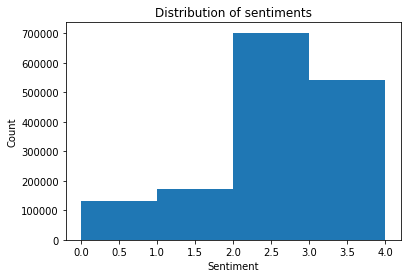

In [12]:
plt.hist(sentiments, align='mid', bins=range(5))
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of sentiments');

## Preprocessing the Data
With our data in hand we need to preprocess our text. These twits are collected by filtering on ticker symbols where these are denoted with a leader $ symbol in the twit itself. For example,

`{'message_body': 'RT @google Our annual look at the year in Google blogging (and beyond) http://t.co/sptHOAh8 $GOOG',
 'sentiment': 0}`

The ticker symbols don't provide information on the sentiment, and they are in every twit, so we should remove them. This twit also has the `@google` username, again not providing sentiment information, so we should also remove it. We also see a URL `http://t.co/sptHOAh8`. Let's remove these too.

The easiest way to remove specific words or phrases is with regex using the `re` module. You can sub out specific patterns with a space:

```python
re.sub(pattern, ' ', text)
```
This will substitute a space with anywhere the pattern matches in the text. Later when we tokenize the text, we'll split appropriately on those spaces.

### Pre-Processing

In [82]:
nltk.download('wordnet')


def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - tokenize by splitting the string on whitespace 
        - removes any single character tokens
    
    Parameters
    ----------
        message : The text message to be preprocessed.
        
    Returns
    -------
        tokens: The preprocessed text into tokens.
    """ 
    #TODO: Implement 
    
    # Lowercase the twit message
    text = message.lower()
    
    # Replace URLs with a space in the message
    pattern = '(www|http:|https:)+[^\s]+[\w]'
    text = re.sub(pattern, ' ', text)
    
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    pattern = '\$[a-z]{3,}'
    text = re.sub(pattern, ' ', text)
    
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    pattern = '@[a-z]'
    text = re.sub(pattern, ' ', text)

    # Replace everything not a letter with a space
    pattern = '[^a-z]'
    text = re.sub(pattern, ' ', text)
    
    # Tokenize by splitting the string on whitespace into a list of words
    tokens = text.split()

    # Lemmatize words using the WordNetLemmatizer. You can ignore any word that is not longer than one character.
    wnl = nltk.stem.WordNetLemmatizer()
    tokens = [wnl.lemmatize(x) for x in tokens if len(x) > 1]

    
    assert type(tokens) == list, 'Tokens should be list'
    return tokens

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cerion\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


>Note: You must ensure that after preprocessing the text should NOT include:
- Numbers
- URLs
- Single character tokens
- Ticker symbols (these should be removed even if they don't appear at the beginning)

### Preprocess All the Twits 
Now we can preprocess each of the twits in our dataset. Apply the function `preprocess` to all the twit messages.

In [95]:
# TODO Implement

tokenized = [preprocess(x) for x in messages]

In [96]:
#View the first output
tokenized[:3]

[['great', 'buy', 'at', 'ill', 'wait'],
 ['tocktwits'],
 ['staanalystalert',
  'for',
  'jefferies',
  'maintains',
  'with',
  'rating',
  'of',
  'hold',
  'setting',
  'target',
  'price',
  'at',
  'usd',
  'our',
  'own',
  'verdict',
  'is',
  'buy']]

### Bag of Words
Now with all of our messages tokenized, we want to create a vocabulary and count up how often each word appears in our entire corpus. Use the [`Counter`](https://docs.python.org/3.1/library/collections.html#collections.Counter) function to count up all the tokens.

In [103]:
from collections import Counter


"""
Create a vocabulary by using Bag of words
"""

# TODO: Implement 

bow = Counter([word for message in tokenized for word in message])

In [109]:
bow.most_common(10)

[('the', 398906),
 ('to', 379525),
 ('is', 284916),
 ('for', 273545),
 ('on', 241919),
 ('of', 211374),
 ('and', 208518),
 ('in', 205351),
 ('this', 203571),
 ('it', 193908)]

### Frequency of Words Appearing in Message
With our vocabulary, now we'll remove some of the most common words such as 'the', 'and', 'it', etc. These words don't contribute to identifying sentiment and are really common, resulting in a lot of noise in our input. If we can filter these out, then our network should have an easier time learning.

We also want to remove really rare words that show up in a only a few twits. Here you'll want to divide the count of each word by the **number of messages** calculated in the code block above (i.e. `len(messages))`. Then remove words that only appear in some small fraction of the messages.

>Note: There is not an exact number for low and high-frequency cut-offs, however there is a correct optimal range.
You should ideally set up low-frequency cut-off from 0.0000002 to 0.000007 (inclusive) and high-frequency from 5 to 20 (inclusive). If the number is too big, we lose lots of important words that we can use in our data.

In [119]:
freqs

{'great': 0.011352639840827902,
 'buy': 0.04930652902759026,
 'at': 0.08945743244552684,
 'ill': 0.000572347723851913,
 'wait': 0.007344913792546559,
 'tocktwits': 0.00017893941253609472,
 'staanalystalert': 0.00263047396334649,
 'for': 0.17670751480933586,
 'jefferies': 0.0006821661358776752,
 'maintains': 0.0005833295650544894,
 'with': 0.044486792720977254,
 'rating': 0.009972157802598174,
 'of': 0.1365456295501967,
 'hold': 0.014309985077615777,
 'setting': 0.002512257672754052,
 'target': 0.010711171116465655,
 'price': 0.023955917597431542,
 'usd': 0.0019108403692482607,
 'our': 0.007886899955426645,
 'own': 0.005794536211006389,
 'verdict': 0.002413421101930866,
 'is': 0.1840530745925414,
 'heard': 0.0008766093242291716,
 'there': 0.016759581656449248,
 'guy': 0.008685344409919832,
 'who': 0.011552896945110174,
 'know': 0.01287846977732702,
 'someone': 0.00335398350139857,
 'think': 0.015686591171891653,
 'somebody': 0.0007105897248725784,
 'something': 0.003882403860440178,
 'o

In [135]:
"""
Set the following variables:
    freqs
    low_cutoff
    high_cutoff
    K_most_common
"""

# TODO Implement 

# Dictionart that contains the Frequency of words appearing in messages.
# The key is the token and the value is the frequency of that word in the corpus.
n = len(messages)
freqs = {k:v/n for k,v in bow.items()}

# Float that is the frequency cutoff. Drop words with a frequency that is lower or equal to this number.
low_cutoff = 0.0000007

# Integer that is the cut off for most common words. Drop words that are the `high_cutoff` most common words.
high_cutoff = 10

# The k most common words in the corpus. Use `high_cutoff` as the k.
K_most_common = [k for k,v in bow.most_common(high_cutoff)]


filtered_words = [word for word in freqs if (freqs[word] > low_cutoff and word not in K_most_common)]
print(K_most_common)
print(f'Count before filter: {len(freqs)}')
print(f'Count after filter: {len(filtered_words)}') 

['the', 'to', 'is', 'for', 'on', 'of', 'and', 'in', 'this', 'it']
Count before filter: 111066
Count after filter: 54619


In [136]:
filtered_words

['great',
 'buy',
 'at',
 'ill',
 'wait',
 'tocktwits',
 'staanalystalert',
 'jefferies',
 'maintains',
 'with',
 'rating',
 'hold',
 'setting',
 'target',
 'price',
 'usd',
 'our',
 'own',
 'verdict',
 'heard',
 'there',
 'guy',
 'who',
 'know',
 'someone',
 'think',
 'somebody',
 'something',
 'stocktwits',
 'reveal',
 'yourself',
 'why',
 'drop',
 'warren',
 'buffet',
 'taking',
 'out',
 'his',
 'position',
 'ba',
 'bear',
 'have',
 'reason',
 'pay',
 'more',
 'attention',
 'ok',
 'good',
 'we',
 're',
 'not',
 'dropping',
 'over',
 'weekend',
 'lol',
 'daily',
 'chart',
 'need',
 'get',
 'back',
 'above',
 'per',
 'week',
 'after',
 'spike',
 'if',
 'no',
 'news',
 'month',
 'bo',
 'then',
 'bingo',
 'what',
 'odds',
 'strong',
 'short',
 'ratio',
 'float',
 'via',
 'unshineave',
 'squeezing',
 'perfect',
 'place',
 'an',
 'option',
 'straddle',
 'near',
 'supporting',
 'trend',
 'eepakm',
 'ytunes',
 'start',
 'new',
 'monday',
 'expect',
 'volume',
 'across',
 'key',
 'company',


### Updating Vocabulary by Removing Filtered Words
Let's creat three variables that will help with our vocabulary.

In [178]:
"""
Set the following variables:
    vocab
    id2vocab
    filtered
"""

#TODO Implement

# A dictionary for the `filtered_words`. The key is the word and value is an id that represents the word. 
vocab = {v:k for k,v in enumerate(filtered_words, start=1)}
# Reverse of the `vocab` dictionary. The key is word id and value is the word. 
id2vocab = {v:k for k,v in vocab.items()}
# tokenized with the words not in `filtered_words` removed.
filtered = [[word for word in message if vocab.get(word) is not None] for message in tokenized]

assert set(vocab.keys()) == set(id2vocab.values()), 'Check vocab and id2vocab dictionaries'

In [180]:
vocab

{'great': 1,
 'buy': 2,
 'at': 3,
 'ill': 4,
 'wait': 5,
 'tocktwits': 6,
 'staanalystalert': 7,
 'jefferies': 8,
 'maintains': 9,
 'with': 10,
 'rating': 11,
 'hold': 12,
 'setting': 13,
 'target': 14,
 'price': 15,
 'usd': 16,
 'our': 17,
 'own': 18,
 'verdict': 19,
 'heard': 20,
 'there': 21,
 'guy': 22,
 'who': 23,
 'know': 24,
 'someone': 25,
 'think': 26,
 'somebody': 27,
 'something': 28,
 'stocktwits': 29,
 'reveal': 30,
 'yourself': 31,
 'why': 32,
 'drop': 33,
 'warren': 34,
 'buffet': 35,
 'taking': 36,
 'out': 37,
 'his': 38,
 'position': 39,
 'ba': 40,
 'bear': 41,
 'have': 42,
 'reason': 43,
 'pay': 44,
 'more': 45,
 'attention': 46,
 'ok': 47,
 'good': 48,
 'we': 49,
 're': 50,
 'not': 51,
 'dropping': 52,
 'over': 53,
 'weekend': 54,
 'lol': 55,
 'daily': 56,
 'chart': 57,
 'need': 58,
 'get': 59,
 'back': 60,
 'above': 61,
 'per': 62,
 'week': 63,
 'after': 64,
 'spike': 65,
 'if': 66,
 'no': 67,
 'news': 68,
 'month': 69,
 'bo': 70,
 'then': 71,
 'bingo': 72,
 'what':

In [181]:
id2vocab

{1: 'great',
 2: 'buy',
 3: 'at',
 4: 'ill',
 5: 'wait',
 6: 'tocktwits',
 7: 'staanalystalert',
 8: 'jefferies',
 9: 'maintains',
 10: 'with',
 11: 'rating',
 12: 'hold',
 13: 'setting',
 14: 'target',
 15: 'price',
 16: 'usd',
 17: 'our',
 18: 'own',
 19: 'verdict',
 20: 'heard',
 21: 'there',
 22: 'guy',
 23: 'who',
 24: 'know',
 25: 'someone',
 26: 'think',
 27: 'somebody',
 28: 'something',
 29: 'stocktwits',
 30: 'reveal',
 31: 'yourself',
 32: 'why',
 33: 'drop',
 34: 'warren',
 35: 'buffet',
 36: 'taking',
 37: 'out',
 38: 'his',
 39: 'position',
 40: 'ba',
 41: 'bear',
 42: 'have',
 43: 'reason',
 44: 'pay',
 45: 'more',
 46: 'attention',
 47: 'ok',
 48: 'good',
 49: 'we',
 50: 're',
 51: 'not',
 52: 'dropping',
 53: 'over',
 54: 'weekend',
 55: 'lol',
 56: 'daily',
 57: 'chart',
 58: 'need',
 59: 'get',
 60: 'back',
 61: 'above',
 62: 'per',
 63: 'week',
 64: 'after',
 65: 'spike',
 66: 'if',
 67: 'no',
 68: 'news',
 69: 'month',
 70: 'bo',
 71: 'then',
 72: 'bingo',
 73: 'wh

In [182]:
filtered[:3]

[['great', 'buy', 'at', 'ill', 'wait'],
 ['tocktwits'],
 ['staanalystalert',
  'jefferies',
  'maintains',
  'with',
  'rating',
  'hold',
  'setting',
  'target',
  'price',
  'at',
  'usd',
  'our',
  'own',
  'verdict',
  'buy']]

### Balancing the classes
Let's do a few last pre-processing steps. If we look at how our twits are labeled, we'll find that 50% of them are neutral. This means that our network will be 50% accurate just by guessing 0 every single time. To help our network learn appropriately, we'll want to balance our classes.
That is, make sure each of our different sentiment scores show up roughly as frequently in the data.

What we can do here is go through each of our examples and randomly drop twits with neutral sentiment. What should be the probability we drop these twits if we want to get around 20% neutral twits starting at 50% neutral? We should also take this opportunity to remove messages with length 0.

In [183]:
balanced = {'messages': [], 'sentiments':[]}

n_neutral = sum(1 for each in sentiments if each == 2)
N_examples = len(sentiments)
keep_prob = (N_examples - n_neutral)/4/n_neutral

for idx, sentiment in enumerate(sentiments):
    message = filtered[idx]
    if len(message) == 0:
        # skip this message because it has length zero
        continue
    elif sentiment != 2 or random.random() < keep_prob:
        balanced['messages'].append(message)
        balanced['sentiments'].append(sentiment) 

(array([130886.,      0., 171396.,      0.,      0., 203764.,      0.,
        308830.,      0., 222923.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

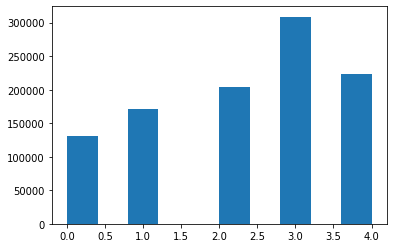

In [193]:
plt.hist(balanced['sentiments'])

If you did it correctly, you should see the following result 

In [184]:
n_neutral = sum(1 for each in balanced['sentiments'] if each == 2)
N_examples = len(balanced['sentiments'])
n_neutral/N_examples

0.19634245166935024

Finally let's convert our tokens into integer ids which we can pass to the network.

In [194]:
token_ids = [[vocab[word] for word in message] for message in balanced['messages']]
sentiments = balanced['sentiments']

## Neural Network
Now we have our vocabulary which means we can transform our tokens into ids, which are then passed to our network. So, let's define the network now!

Here is a nice diagram showing the network we'd like to build: 

#### Embed -> RNN -> Dense -> Softmax
### Implement the text classifier
Before we build text classifier, if you remember from the other network that you built in  "Sentiment Analysis with an RNN"  exercise  - which there, the network called " SentimentRNN", here we named it "TextClassifer" - consists of three main parts: 1) init function `__init__` 2) forward pass `forward`  3) hidden state `init_hidden`. 

This network is pretty similar to the network you built expect in the  `forward` pass, we use softmax instead of sigmoid. The reason we are not using sigmoid is that the output of NN is not a binary. In our network, sentiment scores have 5 possible outcomes. We are looking for an outcome with the highest probability thus softmax is a better choice.

In [388]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model by setting up the layers.
        
        Parameters
        ----------
            vocab_size : The vocabulary size.
            embed_size : The embedding layer size.
            lstm_size : The LSTM layer size.
            output_size : The output size.
            lstm_layers : The number of LSTM layers.
            dropout : The dropout probability.
        """
        
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout
        
        # TODO Implement

        # Setup embedding layer
        self.embedding = nn.Embedding(self.vocab_size, 
                                      self.embed_size, 
                                      padding_idx=0)
        
        # Setup additional layers
        self.RNN = nn.LSTM(input_size=self.embed_size, 
                           hidden_size=self.lstm_size,
                           num_layers=self.lstm_layers,
                           batch_first = False,
                           dropout = self.dropout
                          )
        
        self.Classifier = nn.Sequential(nn.Linear(self.lstm_size, 256),
                          nn.BatchNorm1d(256),
                          nn.ReLU(),
                          nn.Dropout(p=self.dropout),            
                          nn.Linear(256, self.output_size),
                          nn.LogSoftmax()) 


    def init_hidden(self, batch_size):
        """ 
        Initializes hidden state
        
        Parameters
        ----------
            batch_size : The size of batches.
        
        Returns
        -------
            hidden_state
            
        """
        
        # TODO Implement 
        
        
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        
        #Check device 
        device = next(self.parameters())

        h = torch.zeros(self.lstm_layers, batch_size, self.lstm_size).to(device)
        c = torch.zeros(self.lstm_layers, batch_size, self.lstm_size).to(device)
        return (h, c)


    def forward(self, nn_input, hidden_state):
        """
        Perform a forward pass of our model on nn_input.
        
        Parameters
        ----------
            nn_input : The batch of input to the NN.
            hidden_state : The LSTM hidden state.

        Returns
        -------
            logps: log softmax output
            hidden_state: The new hidden state.

        """
        
        # TODO Implement 
        x = self.embedding(nn_input)       
        x, (h, c) = self.RNN(x, hidden_state)
        x = x[-1,:,:] #Only take the last output of the LSTM sequence        
        x = self.Classifier(x)        
        return x, (h, c)

### View Model

In [311]:
# def __init__(self, vocab_size, embed_size, lstm_size, output_size, lstm_layers=1, dropout=0.1):
model = TextClassifier(vocab_size=len(vocab), embed_size=10, lstm_size=6, output_size=5, dropout=0.1, lstm_layers=2)
model.embedding.weight.data.uniform_(-1, 1)
input = torch.randint(0, 1000, (5, 7), dtype=torch.int64)
hidden = model.init_hidden(7)

logps, _ = model.forward(input, hidden)
print(logps)
print(f'input.shape: {input.shape}')
print(f'logps.shape: {logps.shape}')


tensor([[-1.5508, -1.6763, -1.8403, -1.6615, -1.3774],
        [-1.6019, -1.6765, -1.8077, -1.6277, -1.3821],
        [-1.6044, -1.6272, -1.8190, -1.6590, -1.3864],
        [-1.5817, -1.6329, -1.8753, -1.6425, -1.3775],
        [-1.6323, -1.6507, -1.8161, -1.6118, -1.3847],
        [-1.6101, -1.7008, -1.7901, -1.5676, -1.4185],
        [-1.6477, -1.6492, -1.7765, -1.6316, -1.3845]],
       grad_fn=<LogSoftmaxBackward0>)
input.shape: torch.Size([5, 7])
logps.shape: torch.Size([7, 5])


## Training
### DataLoaders and Batching
Now we should build a generator that we can use to loop through our data. It'll be more efficient if we can pass our sequences in as batches. Our input tensors should look like `(sequence_length, batch_size)`. So if our sequences are 40 tokens long and we pass in 25 sequences, then we'd have an input size of `(40, 25)`.

If we set our sequence length to 40, what do we do with messages that are more or less than 40 tokens? For messages with fewer than 40 tokens, we will pad the empty spots with zeros. We should be sure to **left** pad so that the RNN starts from nothing before going through the data. If the message has 20 tokens, then the first 20 spots of our 40 long sequence will be 0. If a message has more than 40 tokens, we'll just keep the first 40 tokens.

In [328]:
def dataloader(messages, labels, sequence_length=30, batch_size=32, shuffle=False, max_minibatches = -1):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    iteration = 0
    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # Left pad!
            start_idx = max(sequence_length - len(token_tensor), 0)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        
        yield batch, label_tensor
        
        iteration+=1
        #Added possible break if we want to train on a smaller subset of the data
        if max_minibatches > 0 and iteration >= max_minibatches:
            break

### Training and  Validation
With our data in nice shape, we'll split it into training and validation sets.

In [300]:
"""
Split data into training and validation datasets. Use an appropriate split size.
The features are the `token_ids` and the labels are the `sentiments`.
"""   

# TODO Implement 
from sklearn.model_selection import train_test_split
train_features, valid_features, train_labels, valid_labels = train_test_split(token_ids, sentiments, test_size=0.2, random_state=42)


In [301]:
print(f'len(train_features): {len(train_features)}')
print(f'len(valid_features): {len(valid_features)}')
print(f'len(train_labels): {len(train_labels)}')
print(f'len(valid_labels): {len(valid_labels)}')

len(train_features): 830239
len(valid_features): 207560
len(train_labels): 830239
len(valid_labels): 207560


In [321]:
text_batch, labels = next(iter(dataloader(train_features, train_labels, sequence_length=20, batch_size=64)))
model = TextClassifier(len(vocab)+1, 200, 128, 5, dropout=0.)
hidden = model.init_hidden(64)
print(f'text_batch.shape: {text_batch.shape}')
print(f'labels.shape: {labels.shape}')
print(f'hidden[0].shape: {hidden[0].shape}')

logps, hidden = model.forward(text_batch, hidden)

text_batch.shape: torch.Size([20, 64])
labels.shape: torch.Size([64])
hidden[0].shape: torch.Size([1, 64, 128])


### Training
It's time to train the neural network!

In [393]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')
model = TextClassifier(len(vocab)+1, 1024, 512, 5, lstm_layers=2, dropout=0.2)
model.embedding.weight.data.uniform_(-1, 1)
model.to(device)

device: cuda


TextClassifier(
  (embedding): Embedding(54620, 1024, padding_idx=0)
  (RNN): LSTM(1024, 512, num_layers=2, dropout=0.2)
  (Classifier): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=5, bias=True)
    (5): LogSoftmax(dim=None)
  )
)

In [394]:
"""
Train your model with dropout. Make sure to clip your gradients.
Print the training loss, validation loss, and validation accuracy for every 100 steps.
"""

epochs = 2
batch_size = 1024
learning_rate = 0.001
gradient_clip_value = 10

print_every = 5
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.train()

train_losses, test_losses = [], []

for epoch in range(epochs):
    print(f'Running epoch {epoch+1}/{epochs}')
    
    steps = 0
    running_loss = 0.0
    num_examples_train = 0
    for text_batch, labels in dataloader(
            train_features, train_labels, batch_size=batch_size, sequence_length=20, shuffle=True, max_minibatches=1000):
        steps += 1
        hidden = model.init_hidden(text_batch.shape[1])
             
        # Set Device
        text_batch, labels = text_batch.to(device), labels.to(device)
        for each in hidden:
            each.to(device)
   
        optimizer.zero_grad()
        output, hidden = model(text_batch, hidden)
        #print(f'output.shape: {output.shape}')
        #print(f'labels.shape: {labels.shape}')
        loss = criterion(output, labels)
        
        loss.backward()
        
        #Clip the gradients
        torch.nn.utils.clip_grad_norm(model.parameters(), gradient_clip_value)
        
        optimizer.step()
        
        running_loss += loss.item()
        num_examples_train += text_batch.shape[1]
        
        
        if steps % print_every == 0:
            with torch.no_grad():
                model.eval()
                
                test_loss = 0.0
                num_examples_test = 0
                
                for text_batch, labels in dataloader(
                    valid_features, valid_labels, batch_size=batch_size, sequence_length=20, shuffle=True, max_minibatches=100):
                 
                    hidden = model.init_hidden(text_batch.shape[1])
                    
                    # Set Device
                    text_batch, labels = text_batch.to(device), labels.to(device)
                    for each in hidden:
                        each.to(device)
                        
                    output, hidden = model(text_batch, hidden)
                    loss = criterion(output, labels)
                    test_loss+= loss.item()
                    num_examples_test += text_batch.shape[1]
            
            # TODO Implement: Print metrics
            print(f'epoch {epoch+1}/{epochs} | Train loss: {running_loss/num_examples_train} | Test loss: {test_loss/num_examples_test}')
            
            train_losses.append(running_loss/num_examples_train)
            test_losses.append(test_loss/num_examples_test)
            
            #Reset the running loss of train since it is not a full epoch
            running_loss = 0.0
            num_examples_train = 0
            
            model.train()
            
print('Training Complete...')

Running epoch 1/2


<ipython-input-394-56d5570149da>:43: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), gradient_clip_value)


epoch 1/2 | Train loss: 0.0015415903180837631 | Test loss: 0.0015497298748232424
epoch 1/2 | Train loss: 0.001329911546781659 | Test loss: 0.0015153693791944533
epoch 1/2 | Train loss: 0.0012661448912695051 | Test loss: 0.0014599064784124494
epoch 1/2 | Train loss: 0.0011858568992465734 | Test loss: 0.0013770283199846744
epoch 1/2 | Train loss: 0.0011636870680376888 | Test loss: 0.0012965837342198939
epoch 1/2 | Train loss: 0.0011026319349184631 | Test loss: 0.001196656710235402
epoch 1/2 | Train loss: 0.0011016227304935454 | Test loss: 0.0011301757150795312
epoch 1/2 | Train loss: 0.0010808440390974283 | Test loss: 0.0010890740028116851
epoch 1/2 | Train loss: 0.0010667779250070452 | Test loss: 0.0010500306566245854
epoch 1/2 | Train loss: 0.0010176504496484996 | Test loss: 0.0010263297730125486
epoch 1/2 | Train loss: 0.0010216923197731375 | Test loss: 0.0010124715440906584
epoch 1/2 | Train loss: 0.00099806027719751 | Test loss: 0.001001101631554775
epoch 1/2 | Train loss: 0.0009972

epoch 1/2 | Train loss: 0.0007131272228434682 | Test loss: 0.0007264599041081964
epoch 1/2 | Train loss: 0.0007123873219825327 | Test loss: 0.0007294654968427494
epoch 1/2 | Train loss: 0.0007393749430775643 | Test loss: 0.0007271291565848514
epoch 1/2 | Train loss: 0.0007279464276507497 | Test loss: 0.0007307668507564813
epoch 1/2 | Train loss: 0.0007477816892787814 | Test loss: 0.0007295561686623841
epoch 1/2 | Train loss: 0.0007267688401043415 | Test loss: 0.000725932081695646
epoch 1/2 | Train loss: 0.0007359167211689055 | Test loss: 0.0007259052991867065
epoch 1/2 | Train loss: 0.0007282838574610651 | Test loss: 0.0007268496073083952
epoch 1/2 | Train loss: 0.0007408908451907337 | Test loss: 0.0007194356218678876
epoch 1/2 | Train loss: 0.000736895005684346 | Test loss: 0.0007267254579346627
epoch 1/2 | Train loss: 0.0007256307173520327 | Test loss: 0.000722618387080729
epoch 1/2 | Train loss: 0.0007503322558477521 | Test loss: 0.0007200328091857955
epoch 1/2 | Train loss: 0.00071

epoch 2/2 | Train loss: 0.0006498064263723791 | Test loss: 0.0006887729658046737
epoch 2/2 | Train loss: 0.0006539144669659436 | Test loss: 0.0006904000759823248
epoch 2/2 | Train loss: 0.0006622487097047269 | Test loss: 0.0006926095753442496
epoch 2/2 | Train loss: 0.0006525569944642485 | Test loss: 0.0006982063694158569
epoch 2/2 | Train loss: 0.0006592919235117733 | Test loss: 0.0006978332123253495
epoch 2/2 | Train loss: 0.0006484354496933519 | Test loss: 0.0006944667745847255
epoch 2/2 | Train loss: 0.000654056714847684 | Test loss: 0.0006921974540455267
epoch 2/2 | Train loss: 0.0006696131662465632 | Test loss: 0.0006928134238114581
epoch 2/2 | Train loss: 0.0006586356088519096 | Test loss: 0.0006887630035635084
epoch 2/2 | Train loss: 0.0006596531136892736 | Test loss: 0.0006926669349195436
epoch 2/2 | Train loss: 0.0006529937731102109 | Test loss: 0.0006928886444075033
epoch 2/2 | Train loss: 0.0006728464853949845 | Test loss: 0.000694180122227408
epoch 2/2 | Train loss: 0.0006

epoch 2/2 | Train loss: 0.0006438818643800914 | Test loss: 0.0006749279814539477
epoch 2/2 | Train loss: 0.0006555216968990862 | Test loss: 0.0006710603355895727
epoch 2/2 | Train loss: 0.0006555015570484102 | Test loss: 0.0006768338807160034
epoch 2/2 | Train loss: 0.0006595656741410494 | Test loss: 0.0006743183091748506
epoch 2/2 | Train loss: 0.000649219227489084 | Test loss: 0.0006726779096061364
epoch 2/2 | Train loss: 0.0006686461507342756 | Test loss: 0.0006719042535405606
epoch 2/2 | Train loss: 0.0006680722930468619 | Test loss: 0.0006733311468269676
epoch 2/2 | Train loss: 0.0006575315841473639 | Test loss: 0.0006725627311971039
epoch 2/2 | Train loss: 0.0006497954251244664 | Test loss: 0.000669558338704519
epoch 2/2 | Train loss: 0.0006595831364393234 | Test loss: 0.0006717512506293133
epoch 2/2 | Train loss: 0.0006430427660234272 | Test loss: 0.0006680171273183077
epoch 2/2 | Train loss: 0.0006511501036584377 | Test loss: 0.0006724041054258123
epoch 2/2 | Train loss: 0.0006

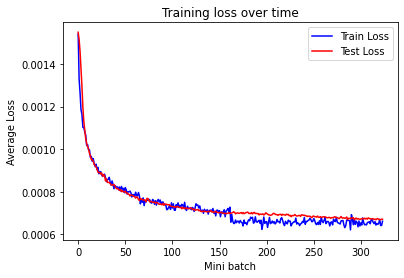

In [395]:
plt.plot(train_losses, 'b', label='Train Loss')
plt.plot(test_losses, 'r', label='Test Loss')
plt.ylabel('Average Loss')  
plt.xlabel('Mini batch')
plt.title('Training loss over time')
plt.legend()

## Making Predictions
### Prediction 
Okay, now that you have a trained model, try it on some new twits and see if it works appropriately. Remember that for any new text, you'll need to preprocess it first before passing it to the network. Implement the `predict` function to generate the prediction vector from a message.

In [334]:
def predict(text, model, vocab):
    """ 
    Make a prediction on a single sentence.

    Parameters
    ----------
        text : The string to make a prediction on.
        model : The model to use for making the prediction.
        vocab : Dictionary for word to word ids. The key is the word and the value is the word id.

    Returns
    -------
        pred : Prediction vector
    """    
    
    # TODO Implement
    
    tokens = preprocess(text)
    
    # Filter non-vocab words
    tokens = [word for word in tokens if vocab.get(word) is not None]

    # Convert words to ids
    tokens = [vocab[word] for word in tokens]
        
    # Adding a batch dimension
    text_input = torch.tensor(tokens).unsqueeze(1)
    
    # Get the NN output
    
    hidden = model.init_hidden(1)

    # Set Device
    #text_batch, labels = text_batch.to(device), labels.to(device)
    #for each in hidden:
    #    each.to(device)

    logps, hidden = model(text_input, hidden)
  
    # Take the exponent of the NN output to get a range of 0 to 1 for each label.
    pred = torch.exp(logps)
    
    return pred

In [396]:
text = "Google is working on self driving cars, I'm bullish on $goog"
model.eval()
model.to("cpu")
predict(text, model, vocab)

tensor([[1.0041e-04, 1.0745e-02, 6.3568e-03, 8.4480e-01, 1.3800e-01]],
       grad_fn=<ExpBackward0>)

In [397]:
np.array([1.0041e-04, 1.0745e-02, 6.3568e-03, 8.4480e-01, 1.3800e-01]).sum()

1.00000221

In [398]:
1 - 8.4480e-01

0.1552

### Questions: What is the prediction of the model? What is the uncertainty of the prediction?

The sentiment is the next most positive or +1 if in the range [-2,2].

The uncertainty is about 15.5%

Now we have a trained model and we can make predictions. We can use this model to track the sentiments of various stocks by predicting the sentiments of twits as they are coming in. Now we have a stream of twits. For each of those twits, pull out the stocks mentioned in them and keep track of the sentiments. Remember that in the twits, ticker symbols are encoded with a dollar sign as the first character, all caps, and 2-4 letters, like $AAPL. Ideally, you'd want to track the sentiments of the stocks in your universe and use this as a signal in your larger model(s).

## Testing
### Load the Data 

In [ ]:
with open(os.path.join('..', '..', 'data', 'project_6_stocktwits', 'test_twits.json'), 'r') as f:
    test_data = json.load(f)

In [336]:
#test_data = twits

In [351]:
test_data

{'data': [{'message_body': '$FITB great buy at 26.00...ill wait',
   'sentiment': 2,
   'timestamp': '2018-07-01T00:00:09Z'},
  {'message_body': '@StockTwits $MSFT',
   'sentiment': 1,
   'timestamp': '2018-07-01T00:00:42Z'},
  {'message_body': '#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy  http://www.stocktargetadvisor.com/toprating',
   'sentiment': 2,
   'timestamp': '2018-07-01T00:01:24Z'},
  {'message_body': '$AMD I heard there’s a guy who knows someone who thinks somebody knows something - on StockTwits.',
   'sentiment': 1,
   'timestamp': '2018-07-01T00:01:47Z'},
  {'message_body': '$AMD reveal yourself!',
   'sentiment': 0,
   'timestamp': '2018-07-01T00:02:13Z'},
  {'message_body': '$AAPL Why the drop? I warren Buffet taking out his position?',
   'sentiment': 1,
   'timestamp': '2018-07-01T00:03:10Z'},
  {'message_body': '$BA bears have 1 reason on 06-29 to pay more attention https://dividend

### Twit Stream

In [337]:
def twit_stream():
    for twit in test_data['data']:
        yield twit

next(twit_stream())

{'message_body': '$FITB great buy at 26.00...ill wait',
 'sentiment': 2,
 'timestamp': '2018-07-01T00:00:09Z'}

Using the `prediction` function, let's apply it to a stream of twits.

In [338]:
def score_twits(stream, model, vocab, universe):
    """ 
    Given a stream of twits and a universe of tickers, return sentiment scores for tickers in the universe.
    """
    for twit in stream:

        # Get the message text
        text = twit['message_body']
        symbols = re.findall('\$[A-Z]{2,4}', text)
        score = predict(text, model, vocab)

        for symbol in symbols:
            if symbol in universe:
                yield {'symbol': symbol, 'score': score, 'timestamp': twit['timestamp']}

In [352]:
universe = {'$BBRY', '$AAPL', '$AMZN', '$BABA', '$YHOO', '$LQMT', '$FB', '$GOOG', '$BBBY', '$JNUG', '$SBUX', '$MU'}

score_stream = score_twits(twit_stream(), model, vocab, universe)

next(score_stream)

{'symbol': '$AMD',
 'score': tensor([[0.0070, 0.0557, 0.4297, 0.4827, 0.0249]], grad_fn=<ExpBackward0>),
 'timestamp': '2018-07-01T00:01:47Z'}

In [374]:
next(score_stream)

{'symbol': '$FSLR',
 'score': tensor([[0.0543, 0.0343, 0.5294, 0.3262, 0.0559]], grad_fn=<ExpBackward0>),
 'timestamp': '2018-07-01T00:43:42Z'}

That's it. You have successfully built a model for sentiment analysis! 

## Submission
Now that you're done with the project, it's time to submit it. Click the submit button in the bottom right. One of our reviewers will give you feedback on your project with a pass or not passed grade. You can continue to the next section while you wait for feedback.